In [1]:
import pandas as pd
import numpy as np
#Import data from EDA_County_Stats_with_temp_v2.ipynb
county_train = pd.read_csv("train_post_EDA.csv")
county_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 6 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   County                                   31 non-null     object 
 1   Energy Burden % of Income                31 non-null     float64
 2   Park within 1/2 Mile                     31 non-null     float64
 3   Imperviousness                           31 non-null     float64
 4   % w/o Internet                           31 non-null     float64
 5   Emergency Visits / 100000 temp residual  31 non-null     float64
dtypes: float64(5), object(1)
memory usage: 1.6+ KB


In [8]:
#Only contains 4 features, and one target, and county name 
#Our target is the residual of emergency visits, when applied a linear fitting
#With respect to max temperature
county_train.sample()

,County,Energy Burden % of Income,Park within 1/2 Mile,Imperviousness,% w/o Internet,Emergency Visits / 100000 temp residual
16,Yuba,3.2,56.0,1.5,8.8,18.263572


In [ ]:
#For our baseline model, we will just return the average target 
from sklearn.dummy import DummyRegressor
#For our MLR model, we will use Linear Regression
from sklearn.linear_model import LinearRegression
#Lets also perform a 5-fold cross validation 
from sklearn.model_selection import KFold
#And use RMSE as our accuracy 

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    if y_true.shape != y_pred.shape:
        raise ValueError(f"Shape mismatch: {y_true.shape=} {y_pred.shape=}")
    return np.sqrt(np.mean((y_true - y_pred) ** 2))


num_splits = 5
#2 models, baseline and MLR
num_models = 6

kfold = KFold(num_splits, random_state=25, shuffle=True)

rmses = np.zeros((num_models, num_splits))

#split counter
i = 0

for train_index, test_index in kfold.split(county_train):

    #training set
    county_tt = county_train.iloc[train_index]

    #holdout set
    county_ho = county_train.iloc[test_index]
    real_county_residual = county_ho[['Emergency Visits / 100000 temp residual']].to_numpy().ravel()


    #BASELINE
    mean_regressor = DummyRegressor(strategy="mean")
    mean_regressor.fit(county_tt[['Energy Burden % of Income', 'Park within 1/2 Mile',
    'Imperviousness','% w/o Internet']], county_tt[['Emergency Visits / 100000 temp residual']])

    baseline_pred = mean_regressor.predict(real_county_residual)
    rmses[0, i] = rmse(real_county_residual, baseline_pred)
    
    #SLR Energy Burden
    slr_energy = LinearRegression()
    slr_energy.fit(county_tt[['Energy Burden % of Income']], county_tt[['Emergency Visits / 100000 temp residual']])
    slr_energy_pred = slr_energy.predict(county_ho[['Energy Burden % of Income']])
    rmses[1, i] = rmse(real_county_residual, slr_energy_pred.ravel())

    #SLR Park
    slr_park = LinearRegression()
    slr_park.fit(county_tt[['Park within 1/2 Mile']], county_tt[['Emergency Visits / 100000 temp residual']])
    slr_park_pred = slr_park.predict(county_ho[['Park within 1/2 Mile']])
    rmses[2, i] = rmse(real_county_residual, slr_park_pred.ravel())

    #SLR Imperviousness
    slr_im = LinearRegression()
    slr_im.fit(county_tt[['Imperviousness']], county_tt[['Emergency Visits / 100000 temp residual']])
    slr_im_pred = slr_im.predict(county_ho[['Imperviousness']])
    rmses[3, i] = rmse(real_county_residual, slr_im_pred.ravel())

    #SLR Internet
    slr_internet = LinearRegression()
    slr_internet.fit(county_tt[['% w/o Internet']], county_tt[['Emergency Visits / 100000 temp residual']])
    slr_internet_pred = slr_internet.predict(county_ho[['% w/o Internet']])
    rmses[4, i] = rmse(real_county_residual, slr_internet_pred.ravel())

    #MLR all 4 features
    mlr = LinearRegression()
    mlr.fit(county_tt[['Energy Burden % of Income', 'Park within 1/2 Mile',
    'Imperviousness','% w/o Internet']], county_tt[['Emergency Visits / 100000 temp residual']])

    mlr_pred = mlr.predict(county_ho[['Energy Burden % of Income', 'Park within 1/2 Mile',
    'Imperviousness','% w/o Internet']])

    rmses[5, i] = rmse(real_county_residual, mlr_pred.ravel())

    i = i+1





In [66]:
# lets look at all the variables 
models = ['baseline', 'slr energy', 'slr park', 'slr imperviousness', 'slr internet', 'mlr all 4']
for i in range (len(rmses)):
    print(models[i]+ " RMSE")
    print(np.mean(rmses[i]))

baseline RMSE
10.571245368576502
slr energy RMSE
9.252400358999793
slr park RMSE
9.970585995159492
slr imperviousness RMSE
10.884275022910392
slr internet RMSE
9.454333974993085
mlr all 4 RMSE
9.43903142729607


In [67]:
#Ok it looks like SLR park and SLR imperviousness performs worse than baseline
#Lets try MLR with energy and internet 
def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    if y_true.shape != y_pred.shape:
        raise ValueError(f"Shape mismatch: {y_true.shape=} {y_pred.shape=}")
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

num_splits = 5
#2 models, baseline and MLR
num_models = 1

kfold = KFold(num_splits, random_state=25, shuffle=True)

rmse_energy_internet = np.zeros((num_models, num_splits))

#split counter
i = 0

for train_index, test_index in kfold.split(county_train):

    #training set
    county_tt = county_train.iloc[train_index]

    #holdout set
    county_ho = county_train.iloc[test_index]
    real_county_residual = county_ho[['Emergency Visits / 100000 temp residual']].to_numpy().ravel()


    #MLR energy and internet 
    mlr_en_in = LinearRegression()
    mlr_en_in.fit(county_tt[['Energy Burden % of Income','% w/o Internet']], county_tt[['Emergency Visits / 100000 temp residual']])

    mlr_en_in_pred = mlr_en_in.predict(county_ho[['Energy Burden % of Income','% w/o Internet']])

    rmse_energy_internet[0, i] = rmse(real_county_residual, mlr_en_in_pred.ravel())

    i = i+1

In [69]:
print('model MLR energy and internet')
print(np.mean(rmse_energy_internet[0]))

model MLR energy and internet
9.409652078405646


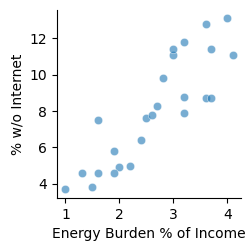

In [77]:
#Well it looks like that combining energy and internet outperforms all 4
#But it doesn't outperform just energy
#Lets see if these two features are correlated with each other
import seaborn as sns
sns.pairplot(data = county_tt,
                x_vars = 'Energy Burden % of Income',
                y_vars = '% w/o Internet',
                plot_kws = {'alpha':.6})

In [ ]:
#It looks like they are both interrelated with each other
#So improvements in energy burden and % without internet is our feature space of choice
